In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.thermal import solve_thermal

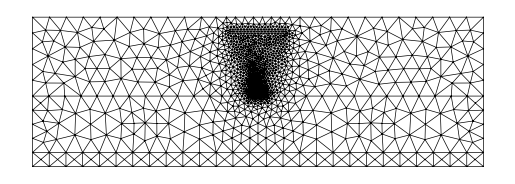

In [2]:
w_sim = 8 * 2
h_clad = 2.8
h_box = 2
w_core = 0.5
h_core = 0.22
h_heater = 0.14
w_heater = 2
offset_heater = 2 + (h_core + h_heater) / 2
h_silicon = 0.5

polygons = OrderedDict(
    bottom=LineString(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
    core=Polygon(
        [
            (-w_core / 2, -h_core / 2),
            (-w_core / 2, h_core / 2),
            (w_core / 2, h_core / 2),
            (w_core / 2, -h_core / 2),
        ]
    ),
    heater=Polygon(
        [
            (-w_heater / 2, -h_heater / 2 + offset_heater),
            (-w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, -h_heater / 2 + offset_heater),
        ]
    ),
    clad=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    box=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    wafer=Polygon(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
)

resolutions = dict(
    core={"resolution": 0.04, "distance": 1},
    clad={"resolution": 0.6, "distance": 1},
    box={"resolution": 0.6, "distance": 1},
    heater={"resolution": 0.1, "distance": 1},
)

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6))
mesh.draw().show()

  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.88it/s]

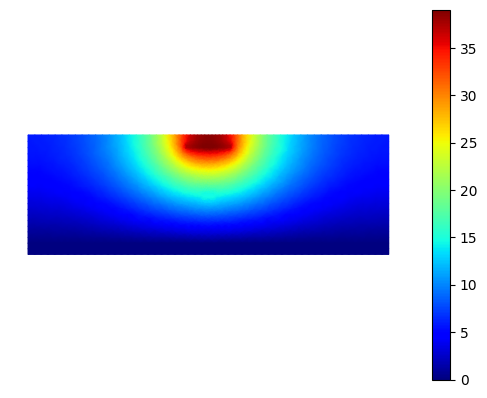

C:\Users\glori\AppData\Local\Temp\ipykernel_31228\3033154107.py:40: DeprecationWarning: The behavior of passing an array directly to `show` is deprecated and will be removed in the future. Use `plot` instead.
  modes[0].show(modes[0].E.real)


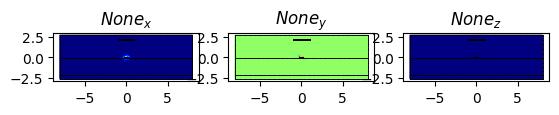

100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


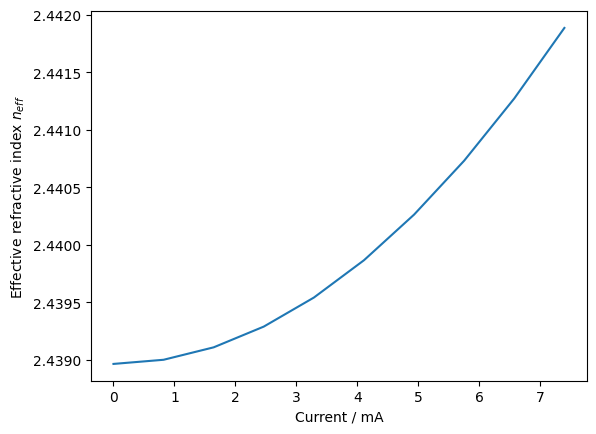

In [3]:
currents = np.linspace(0.0, 7.4e-3, 10)
current_densities = currents / polygons["heater"].area
neffs = []

for current_density in tqdm(current_densities):
    basis0 = Basis(mesh, ElementTriP0(), intorder=4)
    thermal_conductivity_p0 = basis0.zeros()
    for domain, value in {
        "core": 90,
        "box": 1.38,
        "clad": 1.38,
        "heater": 28,
        "wafer": 148,
    }.items():
        thermal_conductivity_p0[basis0.get_dofs(elements=domain)] = value
    thermal_conductivity_p0 *= 1e-12  # 1e-12 -> conversion from 1/m^2 -> 1/um^2

    basis, temperature = solve_thermal(
        basis0,
        thermal_conductivity_p0,
        specific_conductivity={"heater": 2.3e6},
        current_densities={"heater": current_density},
        fixed_boundaries={"bottom": 0},
    )

    if current_density == current_densities[-1]:
        basis.plot(temperature, shading="gouraud", colorbar=True)
        plt.show()

    temperature0 = basis0.project(basis.interpolate(temperature))
    epsilon = basis0.zeros() + (1.444 + 1.00e-5 * temperature0) ** 2
    epsilon[basis0.get_dofs(elements="core")] = (
        3.4777 + 1.86e-4 * temperature0[basis0.get_dofs(elements="core")]
    ) ** 2
    # basis0.plot(epsilon, colorbar=True).show()

    modes = compute_modes(basis0, epsilon, wavelength=1.55, num_modes=1)

    if current_density == current_densities[-1]:
        modes[0].show(modes[0].E.real)

    neffs.append(np.real(modes[0].n_eff))

plt.xlabel("Current / mA")
plt.ylabel("Effective refractive index $n_{eff}$")
plt.plot(currents * 1e3, neffs)
plt.show()